# 8-7. 프로젝트: 한영 번역기 만들기

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import re
import urllib.request
import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

# 0. 데이터 확인

In [3]:
en_train = os.getenv('HOME')+'/aiffel/Going_Deeper_NLP/korean-english-park.train.en'
ko_train = os.getenv('HOME')+'/aiffel/Going_Deeper_NLP/korean-english-park.train.ko'
en_val = os.getenv('HOME')+'/aiffel/Going_Deeper_NLP/korean-english-park.test.en'
ko_val = os.getenv('HOME')+'/aiffel/Going_Deeper_NLP/korean-english-park.test.ko'

def read_text(file_name) :
    with open(file_name, 'r', encoding = 'UTF-8') as f:
        s = f.read().splitlines()
    return s

ko_enc_data = read_text(ko_train)
en_dec_data = read_text(en_train)
ko_val_data = read_text(ko_val)
en_val_data = read_text(en_val)

In [4]:
dataset = [ko_enc_data,en_dec_data,ko_val_data,en_val_data]

for data in dataset:
    print(len(data))
    print(data[:3]) 
    

94123
['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', '그러나 이것은 또한 책상도 필요로 하지 않는다.']
94123
['Much of personal computing is about "can you top this?"', 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.', "Like all optical mice, But it also doesn't need a desk."]
2000
['토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.', '또한 새로운 기술 개발이 어떤 해결책을 제공해 주는데 도움이 될 것이고, 동시 에 통신망 사용자들이 보다 안전하게 통신을 할 수 있도록 도움을 주게 되리라는 희망도 있습니다.', '그래서 클리퍼 칩에 대한 개인적인 해결책은 서서히 자취를 감출 것입니다. 그러나 이 문제는 계속 우리 곁에 존재할 것이며, 당분간은 심각한 상태로 존재할 것입니다.']
2000
['Those involved in the discussions do take seriously the need to address concerns of law enforcement and national security.', 'There is also some hope that new technology developments will help to provide some solutions and at the same time helping to make users of the networks more secure in their communications.', 'So the individual solu

In [5]:
train_data = pd.DataFrame({'ko':ko_enc_data,'en':en_dec_data})
val_data = pd.DataFrame({'ko':ko_val_data,'en':en_val_data})
train_data.head()

,ko,en
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


# 1. 데이터 정제

In [6]:
# train_data 전처리

print("train 전처리전 shape : ",train_data.shape)

# 중복 제외
train_data.drop_duplicates(subset=['ko'], inplace = True )
# null값 제외
train_data = train_data.dropna(how='any')

# 한글, 영어 전처리
train_data['ko'] = train_data['ko'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "").str.strip()
train_data['en'] = train_data['en'].astype(str).str.lower()
train_data['en'] = train_data['en'].str.replace("[^a-zA-Z?.!,]+", " ").str.strip()


# 공백 제외
train_data['ko'].replace('', np.nan, inplace=True)
# null값 제외
train_data = train_data.dropna(how='any')
print("train 전처리후 shape : ",train_data.shape)

train_data.head(3)

train 전처리전 shape :  (94123, 2)
train 전처리후 shape :  (77487, 2)


,ko,en
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐,much of personal computing is about can you to...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다,"like all optical mice, but it also doesn t nee..."


In [7]:
# val_data 전처리

print("val 전처리전 shape : ",val_data.shape)

# 중복 제외
val_data.drop_duplicates(subset=['ko'], inplace = True )
# null값 제외
val_data = val_data.dropna(how='any')

# 한글, 영어 전처리
val_data['ko'] = val_data['ko'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "").str.strip()
val_data['en'] = val_data['en'].astype(str).str.lower()
val_data['en'] = val_data['en'].str.replace("[^a-zA-Z?.!,]+", " ").str.strip()

# 공백 제외
val_data['ko'].replace('', np.nan, inplace=True)
# null값 제외
val_data = val_data.dropna(how='any')
print("val 전처리후 shape : ",val_data.shape)

val_data.head(3)

val 전처리전 shape :  (2000, 2)
val 전처리후 shape :  (1992, 2)


,ko,en
0,토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을...,those involved in the discussions do take seri...
1,또한 새로운 기술 개발이 어떤 해결책을 제공해 주는데 도움이 될 것이고 동시 에 통...,there is also some hope that new technology de...
2,그래서 클리퍼 칩에 대한 개인적인 해결책은 서서히 자취를 감출 것입니다 그러나 이 ...,so the individual solution of the clipper chip...


In [8]:
less_list=[]

min=0
max=5
for i, sentence in enumerate(train_data['ko']):
    if len(sentence)>min and len(sentence)<max:
        less_list.append(sentence)
        print(i,sentence)
        
print(len(less_list)/len(train_data['ko']))

27 어휘
3098 번역
3777 흑색선전
3867 선서하다
4059 보증하다
4377 단장
4503 인기
4593 외딴 곳
4795 월 안경
5135 사기
6661 이수지
7156 이수지
7906 소물리에
8247 면접
8248 지각
8340 남자들
8345 가족
8679 판매원
8682 구조대원
8882 음식
8888 햇빛
8892 보조식품
9477 권성근
9768 권성근
9854 장소
10006 과일
10011 견과류
10014 양파
10070 코브
10112 산부인과
10116 심장질환
10122 유방암
10418 바리백스
10424 대상포진
10438 형간염
12566 자원봉사
12582 지압
12594 숙면
12793 첫인상
12801 세부사항
12802 웹사이트
12824 웹사이트
14865 이수지
15166 신생아
15244 권성근
15391 권성근
15769 권성근
16291 이수지
16364 이수지
18042 이정인
18231 권성근
18368 배신자
18655 권성근
18872 자유
19303 권성근
20701 이수지
20953 버뮤다
20963 나
20967 연락처
21151 이수지
22394 레스토랑
22400 쇼핑
22403 버스투어
22828 이수지
24060 권성근
24713 이수지
25103 이수지
25735 이수지
26561 첫째날
26568 둘째날
26836 계란
26842 커피
26846 아보카도
26851 버섯
26930 이수지
27067 권성근
28219 이수지
29272 이수지
29284 이수지
29715 버스요금
29727 택시요금
29731 서핑스쿨
30563 이수지
31019 권성근
31597 이수지
31947 권성근
32136 퀴노네스
32142 테이블
32149 크로그바
32644 교훈
33126 나중에
33318 요한슨
33838 권성근
34283 첫번째
35337 권성근
35561 권성근
35906 권성근
37988 권성근
38107 권성근
38981 박주영
39257 권성근
40469 박신원
40770 권

In [9]:
print(train_data.iloc[1256])

ko                도 받지 않았다
en    doesn t have an mba.
Name: 1258, dtype: object


train_ko_len min/max/mean :  1 / 59 / 22.66960909571928
train_en_len min/max/mean :  0 / 94 / 22.66960909571928
val_ko_len min/max/mean :  1 / 55 / 15.107429718875501
val_en_len min/max/mean :  1 / 70 / 23.183734939759034


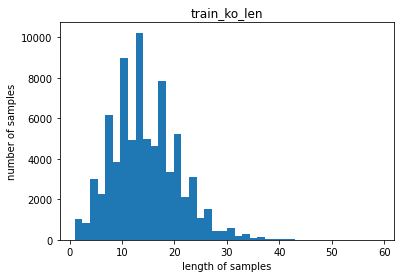

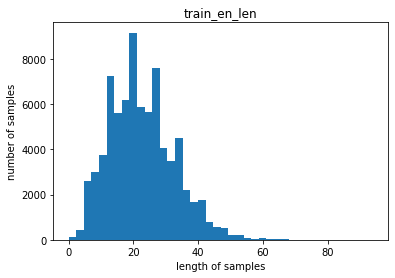

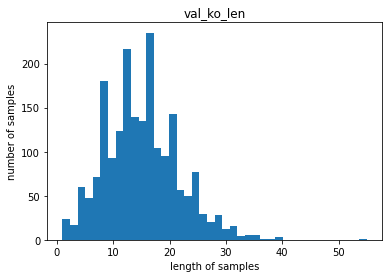

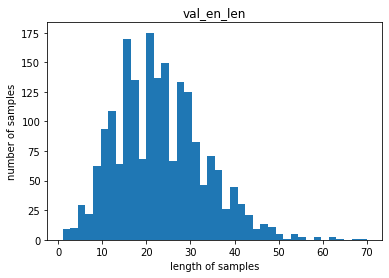

In [10]:
# 길이 분포 출력
import matplotlib.pyplot as plt

train_ko_len = [len(s.split()) for s in train_data['ko']]
train_en_len = [len(s.split()) for s in train_data['en']]
val_ko_len = [len(s.split()) for s in val_data['ko']]
val_en_len = [len(s.split()) for s in val_data['en']]

print('train_ko_len min/max/mean : ',np.min(train_ko_len),'/',np.max(train_ko_len),'/',np.mean(train_en_len))
print('train_en_len min/max/mean : ',np.min(train_en_len),'/',np.max(train_en_len),'/',np.mean(train_en_len))
print('val_ko_len min/max/mean : ',np.min(val_ko_len),'/',np.max(val_ko_len),'/',np.mean(val_ko_len))
print('val_en_len min/max/mean : ',np.min(val_en_len),'/',np.max(val_en_len),'/',np.mean(val_en_len))

plt.title('train_ko_len')
plt.hist(train_ko_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('train_en_len')
plt.hist(train_en_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('val_ko_len')
plt.hist(val_ko_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('val_en_len')
plt.hist(val_en_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
# 해당 길이 몇프로인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list)) * 100)) 

In [12]:
below_threshold_len(5, train_data['ko'])
below_threshold_len(5, val_data['ko'])

전체 샘플 중 길이가 5 이하인 샘플의 비율: 0.6710803102455896
전체 샘플 중 길이가 5 이하인 샘플의 비율: 0.853413654618474


In [13]:
# 해당 데이터 쌍으로 지우기

max_len = 60 #40
min_len = 5 #8

# train_data
train_data = train_data[(train_data['ko'].apply(len) < max_len) & (train_data['ko'].apply(len) > min_len)]
# val_data
val_data = val_data[(val_data['en'].apply(len) < max_len) & (val_data['en'].apply(len) > min_len)]

In [14]:
# 각 열별로 list data 정렬

enc_data = train_data['ko'].tolist()
dec_data = train_data['en'].tolist()
enc_val_data = val_data['ko'].tolist()
dec_val_data = val_data['en'].tolist()

dataset = [enc_data, dec_data, enc_val_data, dec_val_data]
for data in dataset:
    print(len(data))
    print(data[:1])


42267
['개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐']
42267
['much of personal computing is about can you top this?']
170
['컴퓨터에 의한 전자 거래에서 미국의 원유 선물 가격이 배럴 당 달러로 최고치를 기록한 이후에 달러로 센트 급등했다']
170
['jumped cents to . a barrel after setting a high of . .']


# 2. 토크나이저

In [15]:
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [16]:
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# train_data

# 한글 토큰화
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
mecab = Mecab()
enc_list=[]
for sentences in enc_data:  
    enc_list.append([word for word in mecab.morphs(sentences) if not word in stopwords])
    
enc_tensor,enc_tokenizer=tokenize(enc_list)
print(enc_tensor[:1])    

# 영어 토큰화

dec_list=[]
for sentences in dec_data: 
    sentence = sentences.split()
    sentence = ['<start>'] + sentence + ['<end>']
    dec_list.append(sentence)
    
dec_tensor,dec_tokenizer=tokenize(dec_list)
print(dec_tensor[:1]) 

[[  667   609   483   167  1290   844   468   136 18123    24     5  3796
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]]
[[    2   238     5  1132 11801    12    42    85    78   196 10276     3
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


In [17]:
# val_data

# 한글 토큰화
enc_val_list=[]
for sentences in enc_data:  
    enc_val_list.append([word for word in mecab.morphs(sentences) if not word in stopwords])
    
enc_val_tensor,enc_val_tokenizer=tokenize(enc_val_list)
print(enc_val_tensor[:1])    

# 영어 토큰화

dec_val_list=[]
for sentences in dec_data: 
    sentence = sentences.split()
    sentence = ['<start>'] + sentence + ['<end>']
    dec_val_list.append(sentence)
    
dec_val_tensor,dec_val_tokenizer=tokenize(dec_val_list)
print(dec_val_tensor[:1]) 

[[  667   609   483   167  1290   844   468   136 18123    24     5  3796
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]]
[[    2   238     5  1132 11801    12    42    85    78   196 10276     3
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


In [18]:
print("ko word>>idx Vocab Size:", len(enc_tokenizer.word_index))
print("en word>>idx Vocab Size:", len(dec_tokenizer.word_index))

print("ko idx>>word Vocab Size:", len(enc_tokenizer.index_word))
print("en idx>>word Vocab Size:", len(dec_tokenizer.index_word))

ko word>>idx Vocab Size: 29737
en word>>idx Vocab Size: 46690
ko idx>>word Vocab Size: 29737
en idx>>word Vocab Size: 46690


![8-1](8-1.PNG)

# 3. Seq2seq 모델 설계

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units) # weight of encoder. h_enc받아 units크기의 outpput을 반환
        self.w_enc = tf.keras.layers.Dense(units) # weight of decoder
        self.w_com = tf.keras.layers.Dense(1)  # 두개의 weight로 score 계산하는 층
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc) # encoder의 h_state를 w_enc 층에 통과시키고
        h_dec = tf.expand_dims(h_dec, 1) # decoder의 h_state는 encoder의 h_state와 차원을 맞춰
        h_dec = self.w_dec(h_dec) # w_dec층에 통과시키고

        score = self.w_com(tf.nn.tanh(h_dec + h_enc)) # 형태가 맞는 이 둘을 concat후 tanh을 통과시켜 attention score를 뽑고
        
        attn = tf.nn.softmax(score, axis=1) # time step마다 온 attention score들의 총합이 1이 되는 확률형태로 바꿈

        context_vec = attn * h_enc # encoder의 h와 decoder의 최종출력정보인 h까지 반영된 score에 현재시점 enc의 단어를 곱해 context vector 형성
        context_vec = tf.reduce_sum(context_vec, axis=1) # 행방향으로 sum한 값만 남겨 차원 축소

        return context_vec, attn

인코더의 출력인 h_enc와 디코더의 출력인 h_dec를 받아서 어텐션 가중치를 계산하고, 이를 사용하여 가중합을 계산하는 함수 call을 제공

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [22]:
BATCH_SIZE     = 64 #256
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512 #512 #128
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)



In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # 패딩 0 너무 많으니깐 가려서
    loss = loss_object(real, pred) # 실제값과 예측값의 loss 계산하고
    
    mask = tf.cast(mask, dtype=loss.dtype) # 패딩된 부분에 해당하는 손실값을 0으로
    loss *= mask
    
    return tf.reduce_mean(loss) # 손실값의 평균을 리턴

In [24]:
# train fit 

@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0] # = 배치사이즈
    loss = 0
    with tf.GradientTape() as tape:
        enc_out = encoder(src) # encoder의 결과물 (bsz,max_len,h_size)
        h_dec = enc_out[:, -1] # h_size = 모든 시점의 h_state
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

# validation fit 

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0
    enc_out = encoder(src)
    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


In [25]:
# Training start

from tqdm import tqdm
import random

train_loss_history = []
test_loss_history = []

EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        train_loss_history.append((total_loss.numpy() / (batch + 1)))
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val_tensor[idx:idx+BATCH_SIZE],
                                    dec_val_tensor[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss
        test_loss_history.append((total_loss.numpy() / (batch + 1)))
        
        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 50: 100%|██████████| 661/661 [01:48<00:00,  6.07it/s, Test Loss 1.9723]


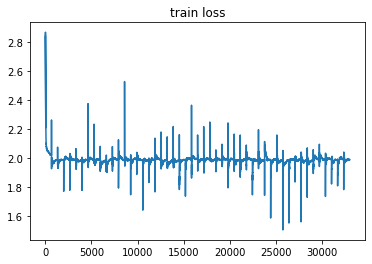

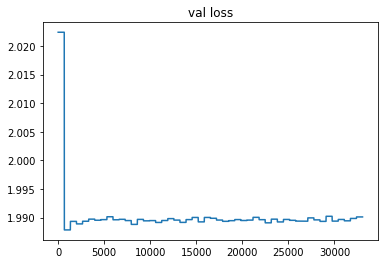

In [26]:
plt.plot(train_loss_history)
plt.title("train loss")
plt.show()

plt.plot(test_loss_history)
plt.title("val loss")
plt.show()

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)
import matplotlib.ticker as ticker

def preprocess_sentence(sentence):
    sentence = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", sentence).strip()
    return sentence

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))

    sentence = preprocess_sentence(sentence)  
    tokenizer = Mecab()
    sentence = tokenizer.morphs(sentence)      
        
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


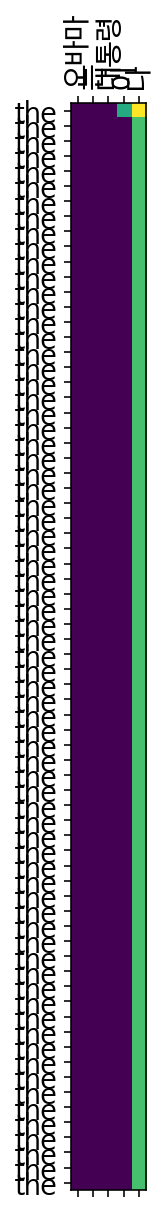

Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


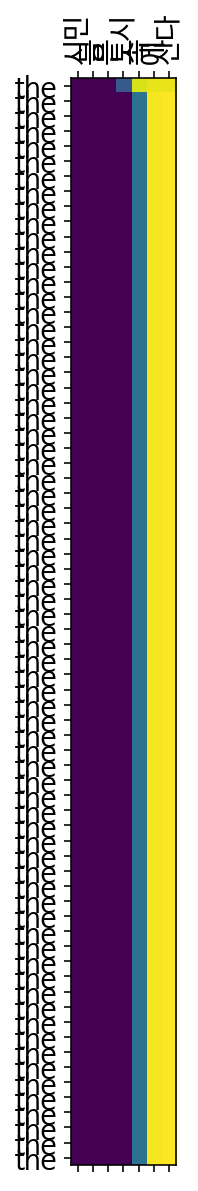

Input: ['커피', '는', '필요', '없', '다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


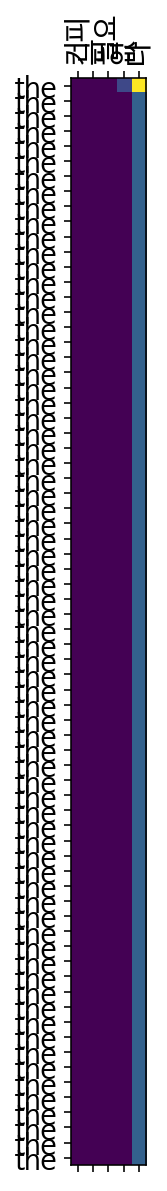

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


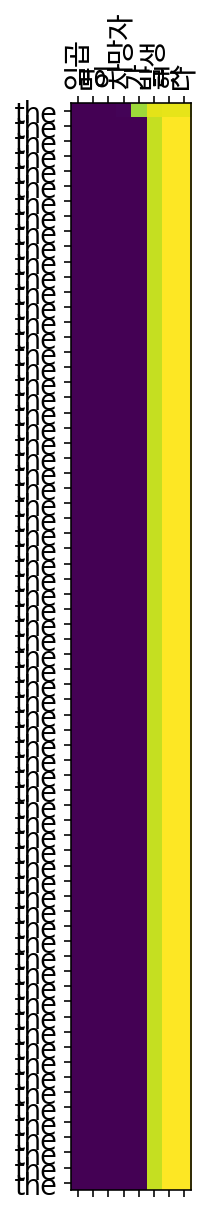

In [28]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

# 회고

결과가 잘 안나와서 속상하지만, 트랜스포머로 비교하겠음.

시도해보기는 하이퍼파라미터를 (배치사이즈, 임베딩디멘션, 유닛사이즈) 여러모로 조절해보았으나 그닥 성능이 뛰어난 것 같지 않음.

seq2seq는 힘들고 재미가 없음.. transformer는 힘들고 재미가 조금 있음ㅋ

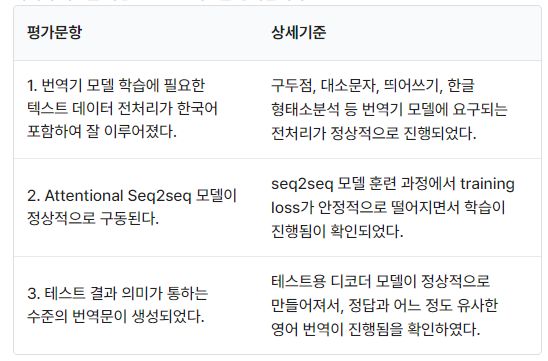
